In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, make_axis_great_again, plot_metrics, plot_losses, plot_lr
from post.utils import parse_epochs

In [3]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '20.05_27.05_rodrigezzzzzzzzzz'

In [4]:
# todo plot iters
def plot_job(ax, job_id, title, training_batch_size, metrics_ylim, n_max_epochs):
    job_log = current_milestone / '{}.out'.format(job_id)

    try:
        exp_name, train_data_amount, _, epochs, lr_reductions = parse_job_log(job_log)
        batch_amount_per_epoch = np.ceil(train_data_amount / training_batch_size)
        n_epochs = int(n_max_epochs)
        xrange = np.arange(1, n_epochs + 1) * batch_amount_per_epoch

        if title:
            title = 'job #{}: "{}"'.format(job_id, title)
        else:
            title = ''

        plot_losses(
            ax, epochs[:n_epochs], xrange,
            title=title, xlabel='# batch iterations'
        )

        plot_metrics(
            ax.twinx(), epochs[:n_epochs], xrange,
            train_metric_ylim=metrics_ylim,
            eval_metric_ylim=metrics_ylim,
            metric_ylabel='average MPJPE relative to pelvis (mm)',
            with_SOTA=True
        )

        plot_lr(ax, lr_reductions, batch_amount_per_epoch)

        make_axis_great_again(ax, xlim=xrange, ylim=[0, 1e2], hide_y=True)
    except StopIteration:
        print('does {} even contain 1 complete epoch ??'.format(job_log))

    
def plot_jobs(jobs, titles, training_batch_size=8, metrics_ylim=[0, 1e2], n_max_epochs=1e3):
    fig, axis = get_figa(len(jobs), 1, heigth=12, width=30)  # 1 job foreach row

    if len(jobs) > 1:
        for ax, job_id, title in zip(axis.ravel(), jobs, titles):
            plot_job(ax, job_id, title, training_batch_size, metrics_ylim, n_max_epochs)
    else:
        plot_job(axis, jobs[0], titles[0], training_batch_size, metrics_ylim, n_max_epochs)

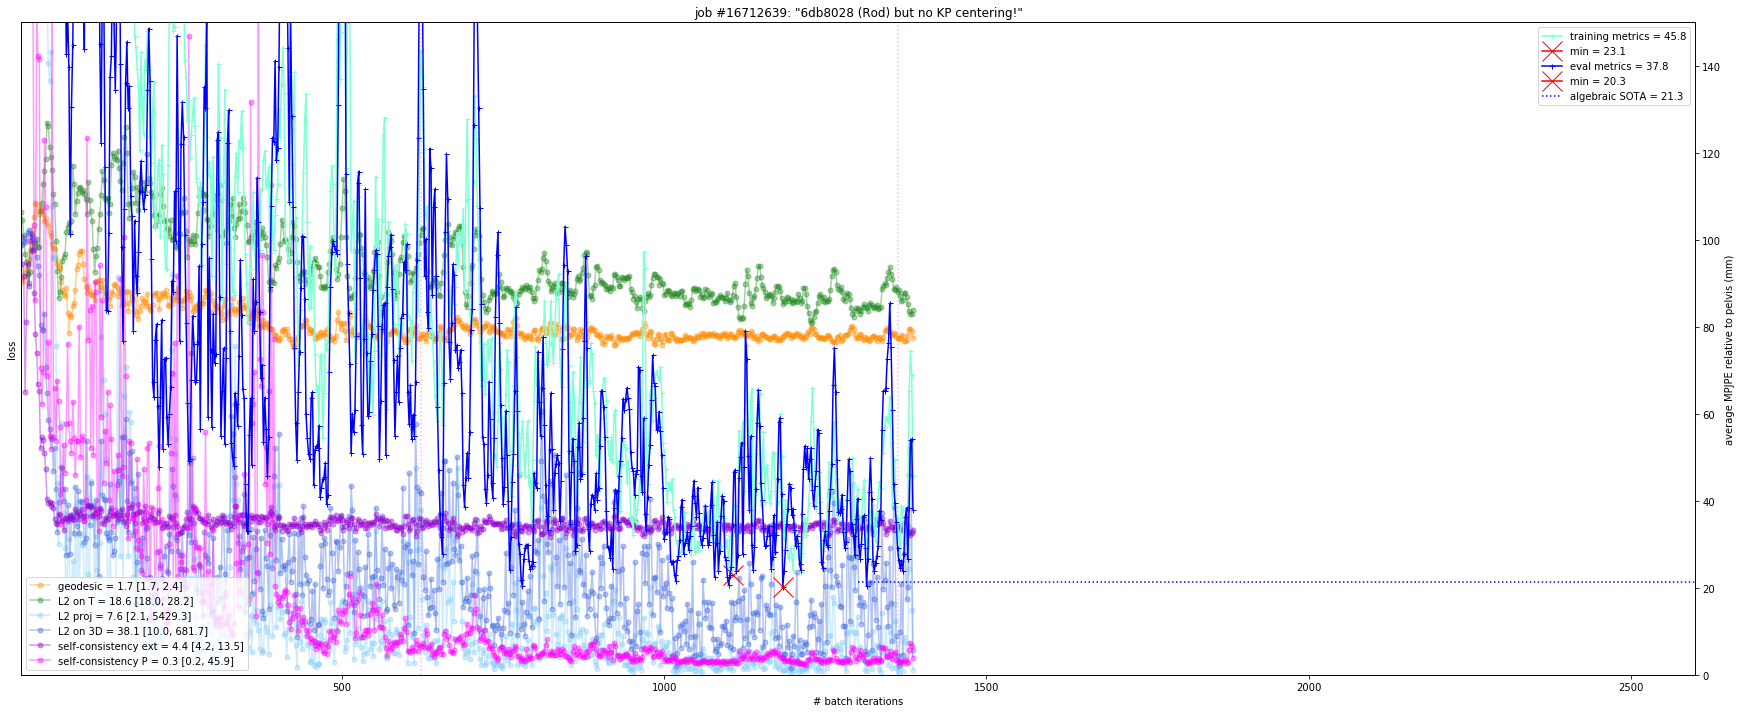

In [6]:
jobs = list(zip(*[
    # pelvis NOT in origin, super R|t, super 3D KPs
    #('16640073', '6f95e67'),  # 16779861
    #('16647158', '=16640073, 10% dataset'),
    #('16809173_16831062', '33f91fc, Fro, 1024, 1e-4'),  # continuing from 16809173  # 16795195, 16797454, 16802162
    #('16822962', '=16809173 but with Rod'),
    
    # pelvis NOT in origin, NOT super R|t, super 3D KPs
    # ...
    
    # pelvis in origin, superv R|t, super 3D KPs
    #('16825120', '~16822962 but with 6D'),
    #('16700068', '1ac51aa but with Rod'),  # 16772316 by mean Fro
     
    # pelvis in origin, NOT superv R|t, super 3D KPs
    #('16712639', '6db8028 (Rod) but no KP centering!'),  # 16711084

    
    
    # pelvis NOT in origin, super R|t, super 2D KPs
    # ...
    
    # pelvis NOT in origin, NOT super R|t, super 2D KPs
    # ...
    
    # pelvis in origin, superv R|t, super 2D KPs
    # ...
    
    # pelvis in origin, NOT superv R|t, super 2D KPs
    #('16731852', '217c24c but wdecy=2, gclip=0.25'),  # 16731537, 16729378, 16721459
]))

plot_jobs(jobs[0], jobs[1], metrics_ylim=[0, 150], n_max_epochs=13e2)